In [1]:
import os

In [2]:
!nvidia-smi

Wed Oct  9 12:06:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1B:00.0 Off |                  N/A |
| 27%   30C    P8              26W / 250W |   8181MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

### help funcs

In [40]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch import nn
import cv2
import torch.nn.functional as F

from pylab import imshow

In [5]:
DATASET_PATH = Path().absolute().parent.parent / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [6]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_intro_ocr_t1.data.MidvPackage)

In [7]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_intro_ocr_t1.data.MidvPackage, 300, course_intro_ocr_t1.data.DataItem)

In [8]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('/home/krotovan/Alexander/ocr/midv500_compressed/31_jpn_drvlic/ground_truth/TS/TS31_19.json'),
 PosixPath('/home/krotovan/Alexander/ocr/midv500_compressed/31_jpn_drvlic/images/TS/TS31_19.tif'))

In [9]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[ 18, 328],
       [392, 346],
       [396, 574],
       [  4, 586]])

[[0.04       0.41      ]
 [0.87111111 0.4325    ]
 [0.88       0.7175    ]
 [0.00888889 0.7325    ]]


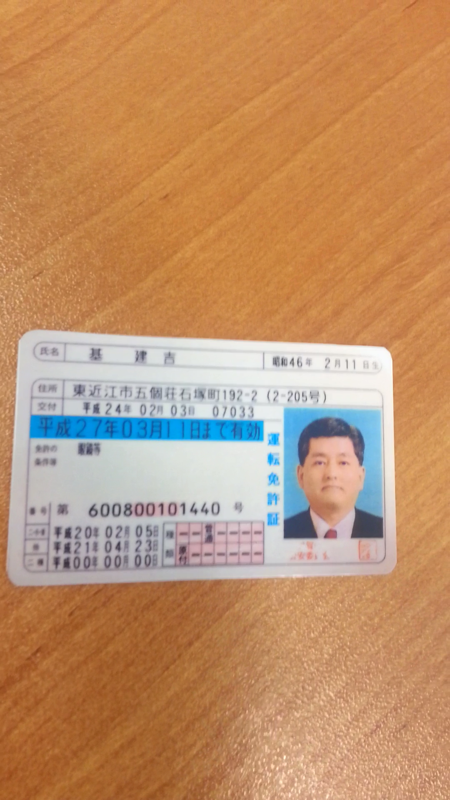

In [10]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

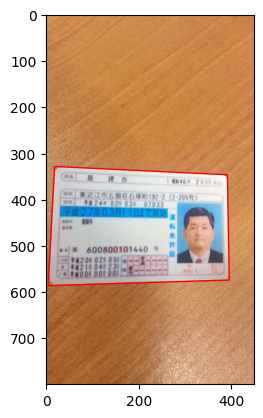

In [11]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [12]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, True)

### Data

In [25]:
img = np.array(data_packs[0][200].image)
print(img.shape)
img = transforms.ToTensor()(img)
print(img.size())
print(img.dtype)
corner_coordinates = np.array(data_packs[0][200].gt_data['quad'])
mask = cv2.fillConvexPoly(np.zeros(img.size()[1:]), corner_coordinates, 1)
mask = torch.FloatTensor(mask)
print(mask.dtype)
print(img.size())
print(mask.size())

(800, 450, 3)
torch.Size([3, 800, 450])
torch.float32
torch.float32
torch.Size([3, 800, 450])
torch.Size([800, 450])


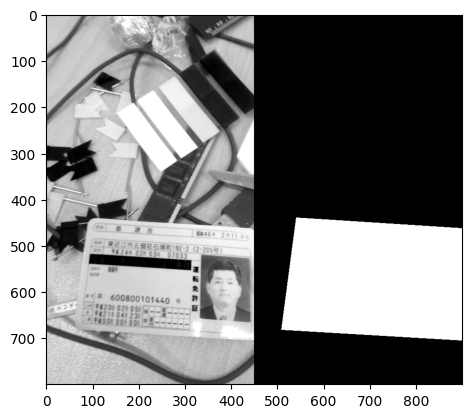

In [14]:
plt.imshow(np.hstack([img.numpy()[0], mask.numpy()[0]]), cmap='gray');

In [27]:
class MIDVDataset(Dataset):
    def __init__(self, dp, validation_flag):
        self.dp = dp
        self.data_idx = []
        for i in range(len(dp)):
            for j in range(len(dp[i])):
                if validation_flag == dp[i][j].is_test_split():
                    self.data_idx.append((i, j))

    def __len__(self):
        return len(self.data_idx)

    def __getitem__(self, idx):
        i, j = self.data_idx[idx]

        img = transforms.ToTensor()(np.array(self.dp[i][j].image))
        
        corner_coordinates = np.array(self.dp[i][j].gt_data['quad'])
        mask = cv2.fillConvexPoly(np.zeros(img.size()[1:]), corner_coordinates, 1)
        mask = torch.FloatTensor(mask)
                
        return img, mask

In [28]:
train_dataset = MIDVDataset(data_packs, False)
valid_dataset = MIDVDataset(data_packs, True)
print(len(train_dataset), len(valid_dataset))

10750 4250


In [29]:
batch_size = 4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,  drop_last=True,  num_workers=47)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=47)

### Crop

In [30]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.input = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.out = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        return self.out((self.encoder(x) + self.input(x)))

In [32]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enocoder1 = Block(3, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder2 = Block(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder3 = Block(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder4 = Block(128, 256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = Block(256, 512)
        
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = Block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = Block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, output_padding=1)
        self.decoder3 = Block(128, 64)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = Block(64, 32)
        
        self.out = nn.Conv2d(32, 1, kernel_size=1)
        
        
    def forward(self, x):
        enc1 = self.enocoder1(x)
        enc2 = self.enocoder2(self.pool1(enc1))
        enc3 = self.enocoder3(self.pool2(enc2))
        enc4 = self.enocoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec = self.upconv1(bottleneck)
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.decoder1(dec)
        
        dec = self.upconv2(dec)
        dec = torch.cat((dec, enc3), dim=1)
        dec = self.decoder2(dec)

        dec = self.upconv3(dec)[:, :, :400, :]
        dec = torch.cat((dec, enc2), dim=1)
        dec = self.decoder3(dec)
        
        dec = self.upconv4(dec)
        dec = torch.cat((dec, enc1), dim=1)
        dec = self.decoder4(dec)
        
        out = self.out(dec)
        return out

In [33]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        assert inputs.size() == targets.size()
        inputs = torch.sigmoid(inputs)
        targets = targets.float()

        intersection = torch.sum(inputs * targets)
        dice = (2. * intersection + smooth) / (torch.sum(inputs) + torch.sum(targets) + smooth)

        return 1. - dice

class CombinationLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return 0.4 * self.dice(inputs, targets) + 0.6 * self.bce(inputs, targets)

In [43]:
import torch
import lightning
import torchmetrics

class LitClassifier(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = CombinationLoss()

    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs).squeeze(1)
        loss = self.criterion(outputs, targets)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs).squeeze(1)
        loss = self.criterion(outputs, targets)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.001)
        return optimizer

In [104]:
torch.cuda.empty_cache()

In [121]:
model = UNet()
lit_model = LitClassifier(model)
trainer = lightning.Trainer(max_epochs=7, accelerator="gpu")
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | UNet            | 8.1 M 
1 | criterion | CombinationLoss | 0     
----------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.457    Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.


### Estimation

In [122]:
# torch.save(model.state_dict(), "UNet_v100500_5ep_weights.pth")

In [231]:
model.load_state_dict(torch.load("UNet_v100500_weights.pth"))

<All keys matched successfully>

In [217]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy, iou_relative_quads

In [218]:
# model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [219]:
def crop(img, only_corners=True):

    img = transforms.ToTensor()(img)
    img_size = img.size()[1:]
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        prediction = model(img)
    mask = torch.sigmoid(prediction) > 0.1
    mask = mask.cpu().squeeze().numpy().astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    x, y = np.array(contour)[:, 0].T
    
    right_bottom = np.argmax(y + x)
    left_bottom = np.argmax(y - x)
    left_top = np.argmax(-y - x)
    right_top = np.argmax(-y + x)

    box = np.array([[x[left_top], y[left_top]], 
                        [x[right_top], y[right_top]], 
                        [x[right_bottom], y[right_bottom]], 
                        [x[left_bottom], y[left_bottom]]], dtype=float)
    
    y = img_size[0]
    x = img_size[1]
    mawtab = np.array([x, y] * 4, dtype=np.float64).reshape(4, 2)
    box /= mawtab
    
    if only_corners:
        return box
    else:
        return box, mask


In [220]:
test_image = np.array(data_packs[0][3].image)
pred, mask = crop(test_image, False)
pred = np.roll(pred, -1, axis=0)
ans = data_packs[0][3].quadrangle

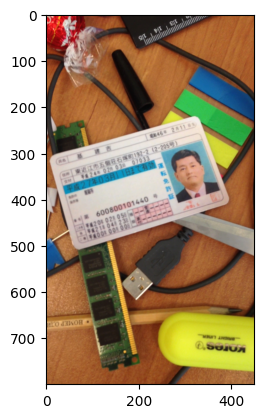

In [221]:
imshow(test_image)

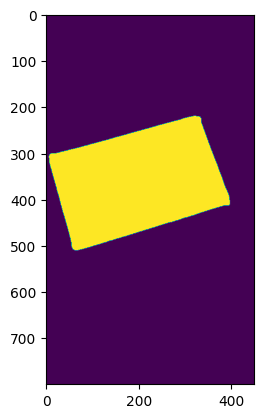

In [222]:
imshow(mask)

In [223]:
print('predicted corners: \n', pred)
print('actual corners: \n', ans)
print('iou: ', iou_relative_quads(pred, ans))

predicted corners: 
 [[0.74       0.2775    ]
 [0.87777778 0.51625   ]
 [0.12888889 0.635     ]
 [0.02       0.3775    ]]
actual corners: 
 [[0.00888889 0.38375   ]
 [0.72888889 0.2725    ]
 [0.88666667 0.50875   ]
 [0.14       0.63875   ]]
iou:  0.9652066555720906


In [232]:
results_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = crop(np.array(dp[i].image))
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)



  6%|█████                                                                               | 3/50 [00:03<00:57,  1.23s/it]

max() arg is an empty sequence



 44%|████████████████████████████████████▌                                              | 22/50 [00:45<01:11,  2.54s/it]

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence



 58%|████████████████████████████████████████████████▏                                  | 29/50 [01:07<01:00,  2.89s/it]

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence



100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:45<00:00,  2.11s/it]


# Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [233]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [234]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [235]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.8424
